# Layers

This notebook introduces a set of layers commonly found in CNNs:

- Batch Normalization
- Dropout
- Pooling



## References

### Batch Normalization
- Original paper: Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
Sergey Ioffe, Christian Szegedy
https://arxiv.org/abs/1502.03167

- Video [Why does Batch Norm work?](https://www.youtube.com/watch?v=nUUqwaxLnWs) Andrew Ng

- PyTorch: 
torch.nn.BatchNorm2d
https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html


- A Gentle Introduction to Batch Normalization for Deep Neural Networks, Jason Brownlee, https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/

### Dropout
- Original paper: Improving neural networks by preventing co-adaptation of feature detectors (2012)
G. E. Hinton∗ , N. Srivastava, A. Krizhevsky, I. Sutskever and R. R. Salakhutdinov
https://arxiv.org/pdf/1207.0580.pdf

- More evaluation: Dropout: A Simple Way to Prevent Neural Networks from Overfitting (2014)
Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, Ruslan Salakhutdinov
https://jmlr.org/papers/v15/srivastava14a.html

- A Gentler Article: A Gentle Introduction to Dropout for Regularizing Deep Neural Networks (2018)
Jason Brownlee
https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

- Another Gentle Article: Understanding And Implementing Dropout In TensorFlow And Keras
Richmond Alake
https://towardsdatascience.com/understanding-and-implementing-dropout-in-tensorflow-and-keras-a8a3a02c1bfa


### Pooling

- Evaluation of Pooling Operations in Convolutional Architectures for Object Recognition
Dominik Scherer, Andreas Muller, and Sven Behnke
http://ais.uni-bonn.de/papers/icann2010_maxpool.pdf

- An alernative to pooling: Striving for Simplicity: The All Convolutional Net, Jost Tobias Springenberg, Alexey Dosovitskiy, Thomas Brox, Martin Riedmiller, https://arxiv.org/abs/1412.6806

- A Gentle Introduction to Pooling Layers for Convolutional Neural Networks, Jason Brownlee, https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/




In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 128

EPOCHS = 20

cuda:0


# Load the dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()]) #, transforms.RandomHorizontalFlip(1.0)])

train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False)

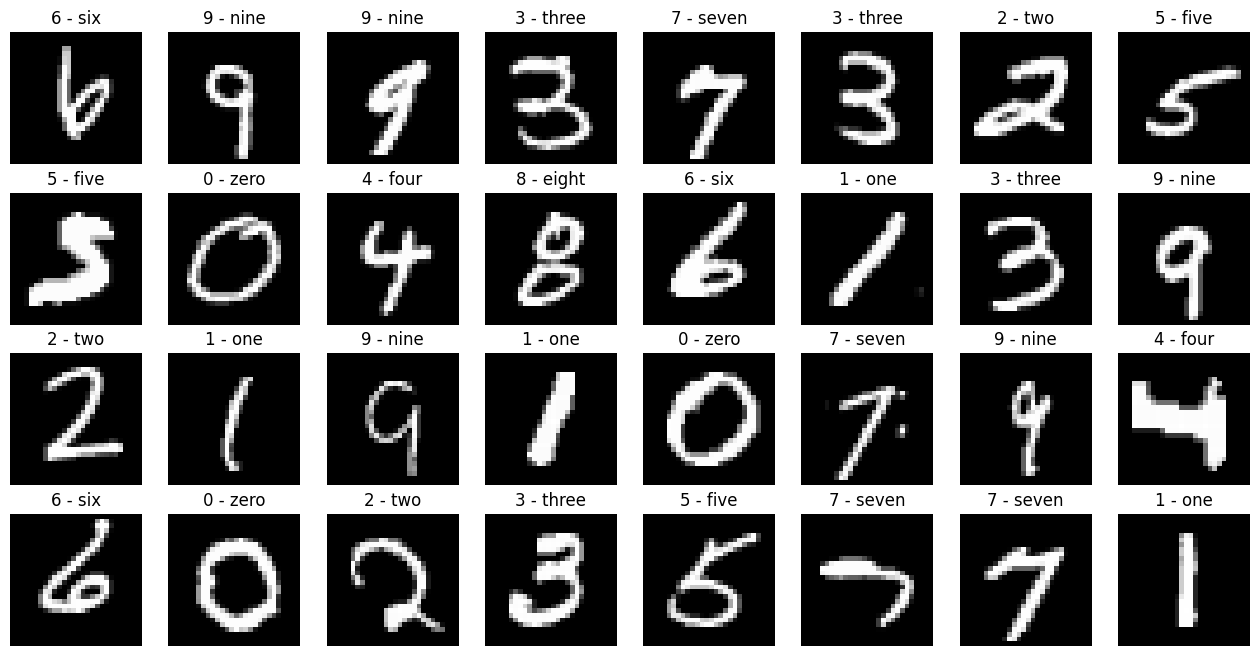

<Figure size 640x480 with 0 Axes>

In [4]:
images, targets = next(iter(train_loader))

vcpi_util.show_images(4,8, images, targets, train_set.classes) 

# Functions to train and evaluate the models

Note: Batch Normalization and Dropout behave differently during training and evaluation.

Batch Normalization: during training normalization is performed with the mean and average of the batch. In evaluation mode the running average and mean computed during training is used instead.

Dropout: during training elements are zeroed with a probability specified in the parameters. The remaining elements are scaled by a factor $f$. During evaluation all elements are considered with equal weight.

$ f = \Large\frac{1}{1-p}$

In [5]:
def train(model, data_loader, epochs, loss_fn, optimizer):

    # sets the model in training mode.
    model.train()

    history = {}
    history['accuracy'] = []
    history['loss'] = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(data_loader, 0):
            
            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)
            
            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        accuracy = 100 * correct / len(train_set)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Accuracy = {accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
        
    print('Finished Training')

    return(history)


def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        logits = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(logits, dim=1)

        correct += (preds.cpu() == targets).sum() 

    return (correct / len(data_loader.dataset)).item() * 100.0

# A simple model with convolutions only

In [6]:
class Conv(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.relu2 = torch.nn.ReLU()
        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.relu3 = torch.nn.ReLU()
        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.relu4 = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(19200, num_classes)
        

    def forward(self, x):    
        
        # input = (bs, 1, 28,28)
        x = self.conv1(x) # -> (bs, 16, 26, 26)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 24, 24)
        x = self.relu2(x)
        x = self.conv3(x) # -> (bs, 48, 22, 22)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 20, 20)
        x = self.relu4(x)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 20 * 20 = 1920)
        x = self.fc1(x)        # -> (bs, 10)

        return(x)


model_Conv = Conv(len(train_set.classes))
model_Conv.to(device)
print(model_Conv)

torchinfo.summary(model_Conv, input_size=(BATCH_SIZE, 1, 28, 28))

Conv(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (fc1): Linear(in_features=19200, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 26, 26]         160
├─ReLU: 1-2                              [128, 16, 26, 26]         --
├─Conv2d: 1-3                            [128, 32, 24, 24]         4,640
├─ReLU: 1-4                              [128, 32, 24, 24]         --
├─Conv2d: 1-5                            [128, 48, 22, 22]         13,872
├─ReLU: 1-6                              [128, 48, 22, 22]         --
├─Conv2d: 1-7                            [128, 48, 20, 20]         20,784
├─ReLU: 1-8                              [128, 48, 20, 20]         --
├─Linear: 1-9                            [128, 10]                 192,010
Total params: 231,466
Trainable params: 231,466
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.30
Input size (MB): 0.40
Forward/backward pass size (MB): 73.41
Params size (MB): 0.93
Estimated To

In [10]:
train_acc = []

optimizer_C = torch.optim.Adam(model_Conv.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

history_C = train(model_Conv, train_loader, EPOCHS, loss_fn, optimizer_C)
train_acc.append(history_C['accuracy'][-1])

Epoch: 000; Accuracy = 99.0333; Elapsed time: 6.7777
Epoch: 001; Accuracy = 99.3400; Elapsed time: 6.8948
Epoch: 002; Accuracy = 99.5167; Elapsed time: 6.8167
Epoch: 003; Accuracy = 99.6650; Elapsed time: 6.7730
Epoch: 004; Accuracy = 99.7033; Elapsed time: 6.8194
Epoch: 005; Accuracy = 99.6950; Elapsed time: 6.7858
Epoch: 006; Accuracy = 99.8050; Elapsed time: 6.7866
Epoch: 007; Accuracy = 99.8033; Elapsed time: 6.7876
Epoch: 008; Accuracy = 99.8717; Elapsed time: 6.7098
Epoch: 009; Accuracy = 99.8217; Elapsed time: 6.7444
Epoch: 010; Accuracy = 99.8650; Elapsed time: 6.7529
Epoch: 011; Accuracy = 99.9317; Elapsed time: 6.7296
Epoch: 012; Accuracy = 99.7933; Elapsed time: 6.7263
Epoch: 013; Accuracy = 99.9400; Elapsed time: 6.6894
Epoch: 014; Accuracy = 99.8767; Elapsed time: 6.7028
Epoch: 015; Accuracy = 99.9383; Elapsed time: 6.7018
Epoch: 016; Accuracy = 99.8783; Elapsed time: 6.7460
Epoch: 017; Accuracy = 99.9000; Elapsed time: 6.6519
Epoch: 018; Accuracy = 99.9633; Elapsed time: 

In [11]:
eval_acc = []

eval_acc.append(evaluate(model_Conv, test_loader))
print(eval_acc[-1])

98.90000224113464


In [13]:
torch.save({
        'model':model_Conv.state_dict(),
        'optimizer': optimizer_C.state_dict()
        },
        f'model_conv_simple.pt')

# Model with Batch Normalization, and Max Pooling

In [15]:
class Conv_II(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)


        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(768, num_classes)
        

    def forward(self, x):    
        
        # input = (bs, 1, 28,28)
        x = self.conv1(x) # -> (bs, 16, 26, 26)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 24, 24)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x)
        
        x = self.conv3(x) # -> (bs, 48, 22, 22)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 20, 20)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 20 * 20 = 1920)
        x = self.fc1(x)        # -> (bs, 10)

        return(x)


model_Conv_II = Conv_II(len(train_set.classes))
model_Conv_II.to(device)
print(model_Conv_II)

torchinfo.summary(model_Conv_II, input_size=(BATCH_SIZE, 1, 28, 28))

Conv_II(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=768, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv_II                                  [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 26, 26]         160
├─BatchNorm2d: 1-2                       [128, 16, 26, 26]         32
├─ReLU: 1-3                              [128, 16, 26, 26]         --
├─Conv2d: 1-4                            [128, 32, 24, 24]         4,640
├─BatchNorm2d: 1-5                       [128, 32, 24, 24]         64
├─ReLU: 1-6                              [128, 32, 24, 24]         --
├─MaxPool2d: 1-7                         [128, 32, 12, 12]         --
├─Conv2d: 1-8                            [128, 48, 10, 10]         13,872
├─BatchNorm2d: 1-9                       [128, 48, 10, 10]         96
├─ReLU: 1-10                             [128, 48, 10, 10]         --
├─Conv2d: 1-11                           [128, 48, 8, 8]           20,784
├─BatchNorm2d: 1-12                      [128, 48, 8, 8]           96
├─R

In [16]:
optimizer_C_II = torch.optim.Adam(model_Conv_II.parameters())

history_C_II = train(model_Conv_II, train_loader, EPOCHS, loss_fn, optimizer_C_II)
train_acc.append(history_C_II['accuracy'][-1])

Epoch: 000; Accuracy = 96.5733; Elapsed time: 7.6402
Epoch: 001; Accuracy = 98.9433; Elapsed time: 7.6179
Epoch: 002; Accuracy = 99.2650; Elapsed time: 7.4940
Epoch: 003; Accuracy = 99.3683; Elapsed time: 7.4601
Epoch: 004; Accuracy = 99.4583; Elapsed time: 7.4279
Epoch: 005; Accuracy = 99.5933; Elapsed time: 7.5724
Epoch: 006; Accuracy = 99.6317; Elapsed time: 7.3995
Epoch: 007; Accuracy = 99.7033; Elapsed time: 7.5718
Epoch: 008; Accuracy = 99.7500; Elapsed time: 7.5325
Epoch: 009; Accuracy = 99.6833; Elapsed time: 7.3428
Epoch: 010; Accuracy = 99.8100; Elapsed time: 7.3330
Epoch: 011; Accuracy = 99.7650; Elapsed time: 7.3396
Epoch: 012; Accuracy = 99.8667; Elapsed time: 7.3150
Epoch: 013; Accuracy = 99.8617; Elapsed time: 7.3451
Epoch: 014; Accuracy = 99.8367; Elapsed time: 7.3189
Epoch: 015; Accuracy = 99.7750; Elapsed time: 7.5368
Epoch: 016; Accuracy = 99.9383; Elapsed time: 7.3156
Epoch: 017; Accuracy = 99.8750; Elapsed time: 7.3264
Epoch: 018; Accuracy = 99.8583; Elapsed time: 

In [17]:
eval_acc.append(evaluate(model_Conv_II, test_loader))
print(eval_acc[-1])

99.21000003814697


In [18]:
torch.save({
        'model':model_Conv_II.state_dict(),
        'optimizer': optimizer_C_II.state_dict()
        },
        f'model_conv_bn_mp.pt')

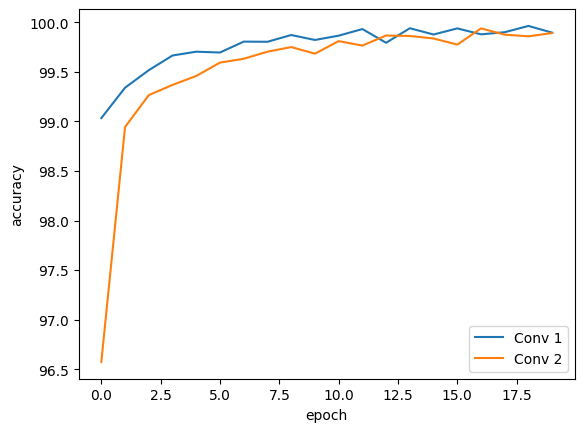

In [19]:
vcpi_util.show_histories([history_C, history_C_II], ['Conv 1', 'Conv 2'])    

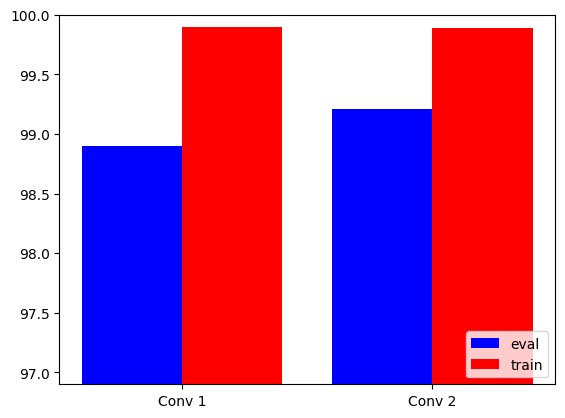

In [20]:
vcpi_util.show_accuracies(train_acc, eval_acc, ['Conv 1', 'Conv 2'])

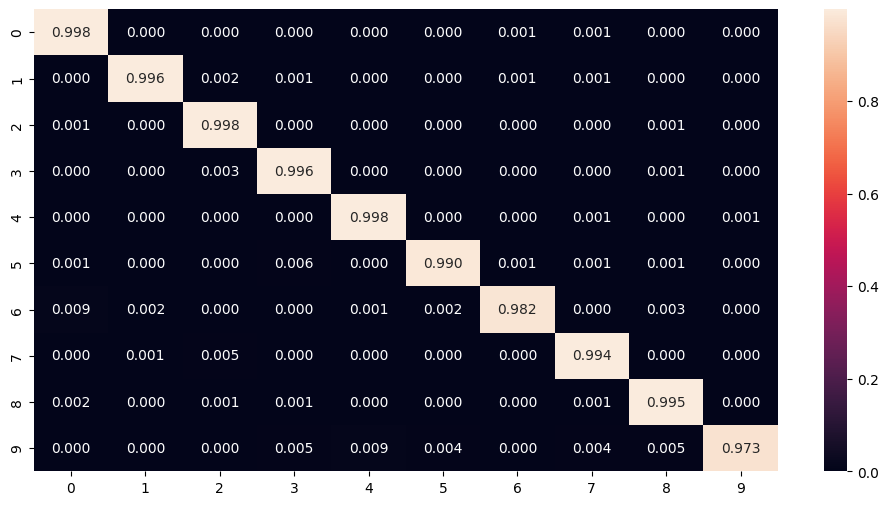

In [21]:
def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes))  

build_confusion_matrix(model_Conv_II, test_loader)     